In [1]:
# @title Install and load dependencies

# Install required libraries
!pip install opencv-python numpy matplotlib openpiv tifffile

# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from scipy.ndimage import map_coordinates
from openpiv.pyprocess import extended_search_area_piv
from openpiv.validation import sig2noise_val
from openpiv.filters import replace_outliers
from openpiv.scaling import uniform
import matplotlib.cm as cm
import pandas as pd
import gc
import glob

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: importlib_resources
    Found existing installation: importlib_resources 6.4.5
    Uninstalling importlib_resources-6.4.5:
      Successfully uninstalled importlib_resources-6.4.5
Mounted at /content/drive


In [46]:
# Set input and output paths
input_folder = '/content/drive/Shareddrives/PIV-analysis/Jammindata2_for_analysis_A-B/'  # Input folder
output_folder = '/content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/'  # Output folder
os.makedirs(output_folder, exist_ok=True)

In [42]:
# @title PIV analysis (works)
summary_interval = 10  # @param {type:"number"}
pixel_size_um = 1.73  # @param {type:"number"}
time_interval_min = 20  # @param {type:"number"}


# Define functions
def load_tiff_video(file_path):
    """
    Load a multi-frame TIFF video as a list of frames.
    """
    print(f"Loading: {file_path}")
    tiff_frames = imread(file_path)
    if len(tiff_frames.shape) == 4:  # Multi-frame RGB TIFF
        return [frame for frame in tiff_frames]
    elif len(tiff_frames.shape) == 3:  # Multi-frame grayscale
        return [tiff_frames[i] for i in range(tiff_frames.shape[0])]
    else:
        raise ValueError(f"Unexpected TIFF format with shape {tiff_frames.shape}")

def convert_to_grayscale(image):
    if len(image.shape) == 3:  # RGB image
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif len(image.shape) == 2:  # Already grayscale
        return image
    else:
        raise ValueError(f"Unexpected image format with shape {image.shape}")

def piv_analysis(image1, image2):
    assert len(image1.shape) == 2 and len(image2.shape) == 2, "Images must be 2D arrays."
    window_size = 32
    overlap = 16
    search_area_size = 32

    u, v, sig2noise = extended_search_area_piv(
        image1.astype(np.int32),
        image2.astype(np.int32),
        window_size=window_size,
        overlap=overlap,
        dt=1,
        search_area_size=search_area_size,
    )
    flags = sig2noise > 1.3
    u, v = replace_outliers(u, v, flags, method='localmean', max_iter=3, kernel_size=2)
    x, y = np.meshgrid(
        np.arange(0, u.shape[1]) * window_size + window_size / 2,
        np.arange(0, u.shape[0]) * window_size + window_size / 2
    )
    return x, y, u, v

def visualize_colored_flow_field(x, y, u, v, image_shape, save_path=None):
    angles = np.arctan2(v, u)
    norm = plt.Normalize(vmin=-np.pi, vmax=np.pi)
    colors = cm.hsv(norm(angles))
    fig, ax = plt.subplots(figsize=(image_shape[1] / 100, image_shape[0] / 100), dpi=100)
    ax.set_xlim(0, image_shape[1])
    ax.set_ylim(image_shape[0], 0)
    ax.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            ax.arrow(
                x[i, j], y[i, j], u[i, j], v[i, j],
                color=colors[i, j], head_width=3, head_length=3
            )
    if save_path:
        fig.canvas.draw()
        image_array = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image_array = image_array.reshape(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), 4)
        imwrite(save_path, image_array[..., :3])
        plt.close(fig)


# Updated loop for sequential file handling
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith('.tiff') or filename.endswith('.tif'):
        video_name = os.path.splitext(filename)[0]
        video_path = os.path.join(input_folder, filename)

        print(f"Processing video: {video_name}")

        # Load and preprocess the video
        frames = load_tiff_video(video_path)
        grayscale_frames = [convert_to_grayscale(frame) for frame in frames]
        video_output_folder = os.path.join(output_folder, video_name)
        os.makedirs(video_output_folder, exist_ok=True)

        # Subfolders for flow field images and summary intervals
        frame_pairs_folder = os.path.join(video_output_folder, "frame_pairs")
        os.makedirs(frame_pairs_folder, exist_ok=True)
        summary_intervals_folder = os.path.join(video_output_folder, "summary_intervals")
        os.makedirs(summary_intervals_folder, exist_ok=True)

        # Initialize metrics and cumulative flow variables
        metrics_list = []
        cumulative_u, cumulative_v = None, None
        frame_counter = 0
        overall_u, overall_v = None, None

        for i in range(len(grayscale_frames) - 1):
            img1 = grayscale_frames[i]
            img2 = grayscale_frames[i + 1]
            x, y, u_raw, v_raw = piv_analysis(img1, img2)

            # Compute calibrated values for metrics
            u_calibrated = u_raw * pixel_size_um / time_interval_min
            v_calibrated = v_raw * pixel_size_um / time_interval_min
            flow_magnitudes_calibrated = np.sqrt(u_calibrated**2 + v_calibrated**2)

            # Compute metrics
            avg_velocity = flow_magnitudes_calibrated.mean()
            avg_direction = np.arctan2(v_calibrated, u_calibrated).mean()
            max_magnitude = flow_magnitudes_calibrated.max()
            divergence = np.gradient(u_calibrated, axis=1).mean() + np.gradient(v_calibrated, axis=0).mean()
            end_time_point = (i + 1) * time_interval_min

            metrics_list.append({
                "Time Point": f"{i+1}-{i+2}",
                "End Time Point (min)": end_time_point,
                "Avg Velocity (µm/min)": avg_velocity,
                "Avg Direction (degrees)": np.degrees(avg_direction),
                "Max Flow Magnitude (µm/min)": max_magnitude,
                "Divergence (1/min)": divergence
            })

            # Update cumulative raw flows for visualization
            if overall_u is None:
                overall_u, overall_v = u_raw, v_raw
            else:
                overall_u += u_raw
                overall_v += v_raw

            if cumulative_u is None:
                cumulative_u, cumulative_v = u_raw, v_raw
            else:
                cumulative_u += u_raw
                cumulative_v += v_raw

            # Save individual flow field visualization
            flow_field_path = os.path.join(frame_pairs_folder, f"flow_{i+1}-{i+2}.tiff")
            visualize_colored_flow_field(x, y, u_raw, v_raw, img1.shape, save_path=flow_field_path)

            # Clear memory for individual flow fields
            del u_raw, v_raw
            gc.collect()

            # Save cumulative flow at specified interval
            frame_counter += 1
            if frame_counter == summary_interval or i == len(grayscale_frames) - 2:
                summary_path = os.path.join(summary_intervals_folder, f"summary_flow_{i+1}.tiff")
                visualize_colored_flow_field(x, y, cumulative_u, cumulative_v, img1.shape, save_path=summary_path)
                cumulative_u, cumulative_v = None, None  # Reset cumulative flow
                frame_counter = 0
                gc.collect()

        # Save metrics to CSV
        metrics_df = pd.DataFrame(metrics_list)
        summary_csv_path = os.path.join(video_output_folder, f"{video_name}_flow_summary.csv")
        metrics_df.to_csv(summary_csv_path, index=False)
        print(f"Metrics saved to: {summary_csv_path}")

        # Save overall summary flow field
        summary_image_path = os.path.join(video_output_folder, "summary_flow_field.tiff")
        visualize_colored_flow_field(x, y, overall_u, overall_v, grayscale_frames[0].shape, save_path=summary_image_path)
        print(f"Summary flow field saved to: {summary_image_path}")

        # Clear memory for the next file
        del frames, grayscale_frames, cumulative_u, cumulative_v, metrics_df, overall_u, overall_v
        gc.collect()
        print(f"Memory cleared for: {video_name}")


Processing video: B8_frames1-60
Loading: /content/drive/Shareddrives/PIV-analysis/reserve/B8_frames1-60.tif


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Metrics saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/B8_frames1-60/B8_frames1-60_flow_summary.csv
Summary flow field saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/B8_frames1-60/summary_flow_field.tiff
Memory cleared for: B8_frames1-60


In [43]:
# @title Plot graphs / video

def plot_metrics_from_csv(input_folder, output_folder):
    """
    Generate improved plots for each video based on saved CSV files.

    Parameters:
    - input_folder: Folder containing the CSV files.
    - output_folder: Folder to save plots.
    """
    csv_files = glob.glob(os.path.join(input_folder, "**", "*_flow_summary.csv"), recursive=True)

    for csv_file in csv_files:
        video_name = os.path.basename(csv_file).replace("_flow_summary.csv", "")
        metrics_df = pd.read_csv(csv_file)

        video_output_folder = os.path.join(output_folder, video_name)
        os.makedirs(video_output_folder, exist_ok=True)

        # Use "End Time Point (min)" as x-axis
        x_values = metrics_df["End Time Point (min)"]

        # Plot Average Velocity
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, metrics_df["Avg Velocity (µm/min)"], marker='o', color='#9467bd', label='Avg Velocity')
        plt.title(f"Average Velocity - {video_name}", fontsize=16)
        plt.xlabel("Time (min)", fontsize=14)
        plt.ylabel("Average Velocity (µm/min)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)
        avg_velocity_path = os.path.join(video_output_folder, f"{video_name}_avg_velocity.png")
        plt.savefig(avg_velocity_path, bbox_inches='tight')
        plt.close()
        print(f"Avg Velocity plot saved to: {avg_velocity_path}")

        # Plot Average Direction
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, metrics_df["Avg Direction (degrees)"], marker='s', color='#ff7f0e', label='Avg Direction (degrees)')
        plt.title(f"Average Flow Direction - {video_name}", fontsize=16)
        plt.xlabel("Time (min)", fontsize=14)
        plt.ylabel("Average Direction (degrees)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)
        avg_direction_path = os.path.join(video_output_folder, f"{video_name}_avg_direction.png")
        plt.savefig(avg_direction_path, bbox_inches='tight')
        plt.close()
        print(f"Avg Direction plot saved to: {avg_direction_path}")

        # Plot Maximum Flow Magnitude
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, metrics_df["Max Flow Magnitude (µm/min)"], marker='^', color='#2ca02c', label='Max Flow Magnitude')
        plt.title(f"Maximum Flow Magnitude - {video_name}", fontsize=16)
        plt.xlabel("Time (min)", fontsize=14)
        plt.ylabel("Max Flow Magnitude (µm/min)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)
        max_flow_magnitude_path = os.path.join(video_output_folder, f"{video_name}_max_flow_magnitude.png")
        plt.savefig(max_flow_magnitude_path, bbox_inches='tight')
        plt.close()
        print(f"Max Flow Magnitude plot saved to: {max_flow_magnitude_path}")

        # Plot Divergence
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, metrics_df["Divergence (1/min)"], marker='d', color='#d62728', label='Divergence')
        plt.title(f"Divergence Over Time - {video_name}", fontsize=16)
        plt.xlabel("Time (min)", fontsize=14)
        plt.ylabel("Divergence (1/min)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Divergence')
        plt.legend(fontsize=12)
        divergence_path = os.path.join(video_output_folder, f"{video_name}_divergence.png")
        plt.savefig(divergence_path, bbox_inches='tight')
        plt.close()
        print(f"Divergence plot saved to: {divergence_path}")

# Call the function to generate improved plots
plot_metrics_from_csv(output_folder, output_folder)


Avg Velocity plot saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A10_frames0-60/A10_frames0-60_avg_velocity.png
Avg Direction plot saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A10_frames0-60/A10_frames0-60_avg_direction.png
Max Flow Magnitude plot saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A10_frames0-60/A10_frames0-60_max_flow_magnitude.png
Divergence plot saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A10_frames0-60/A10_frames0-60_divergence.png
Avg Velocity plot saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A11_frames0-60/A11_frames0-60_avg_velocity.png
Avg Direction plot saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A11_frames0-60/A11_frames0-60_avg_direction.png
Max Flow Magnitude plot saved to: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A11_frames0-60/A11_frames0-60_max_flow_magnitude.

In [48]:
# @title Concatenate csv files

import os
import glob
import pandas as pd


def concatenate_csv_files(input_folder, output_folder, output_filename="combined_results_A-B.csv"):
    """
    Concatenate all CSV files in the input folder and its subfolders into a single CSV file.

    Parameters:
    - input_folder: Path to the folder containing individual CSV files in subfolders.
    - output_folder: Path to the folder where the combined CSV file will be saved.
    - output_filename: Name of the output CSV file.
    """
    # Find all CSV files in the input folder and its subfolders
    csv_files = glob.glob(os.path.join(output_folder, "**", "*_frames*_flow_summary.csv"), recursive=True)

    if not csv_files:
        print(f"No CSV files found in the output_folder: {output_folder}")
        return

    # Debug: List found files
    print(f"Found {len(csv_files)} CSV files:")
    for file in csv_files:
        print(f" - {file}")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    combined_df = pd.DataFrame()  # Initialize an empty DataFrame

    for csv_file in csv_files:
        try:
            # Extract the CSV file name (without the folder path)
            csv_file_name = os.path.basename(csv_file)

            # Read the CSV file
            metrics_df = pd.read_csv(csv_file)

            # Add a column to track the source file name
            metrics_df["CSV File Name"] = csv_file_name

            # Concatenate the data
            combined_df = pd.concat([combined_df, metrics_df], ignore_index=True)
            print(f"Added data from {csv_file_name}")
        except Exception as e:
            print(f"Error processing file {csv_file}: {e}")

    # Save the combined DataFrame to a single CSV file
    output_path = os.path.join(output_folder, output_filename)
    combined_df.to_csv(output_path, index=False)
    print(f"Combined results saved to: {output_path}")


# Example usage

concatenate_csv_files(input_folder, output_folder, output_filename="combined_results_A-B.csv")


Found 24 CSV files:
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A10_frames0-60/A10_frames0-60_flow_summary.csv
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A11_frames0-60/A11_frames0-60_flow_summary.csv
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A12_frames0-60/A12_frames0-60_flow_summary.csv
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A1_frames0-60/A1_frames0-60_flow_summary.csv
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A2_frames0-60/A2_frames0-60_flow_summary.csv
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A3_frames0-60/A3_frames0-60_flow_summary.csv
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A4_frames0-60/A4_frames0-60_flow_summary.csv
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A5_frames0-60/A5_frames0-60_flow_summary.csv
 - /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/A6

Using concatenated file: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/combined_results_A-B.csv


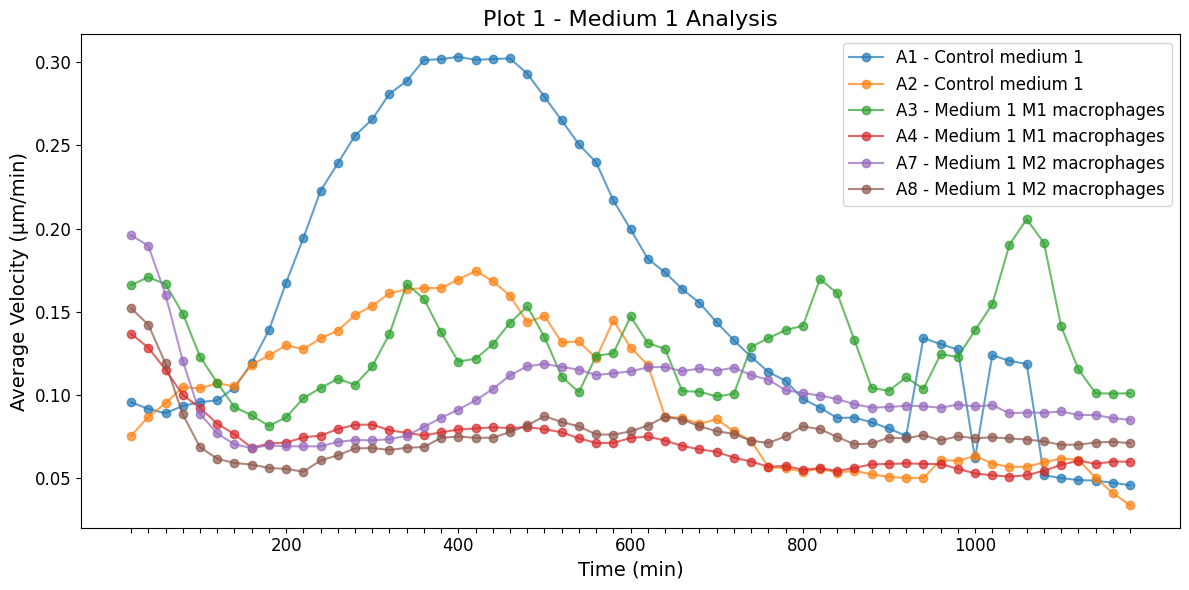

Plot saved for Plot 1 - Medium 1 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_1_-_medium_1_analysis.png


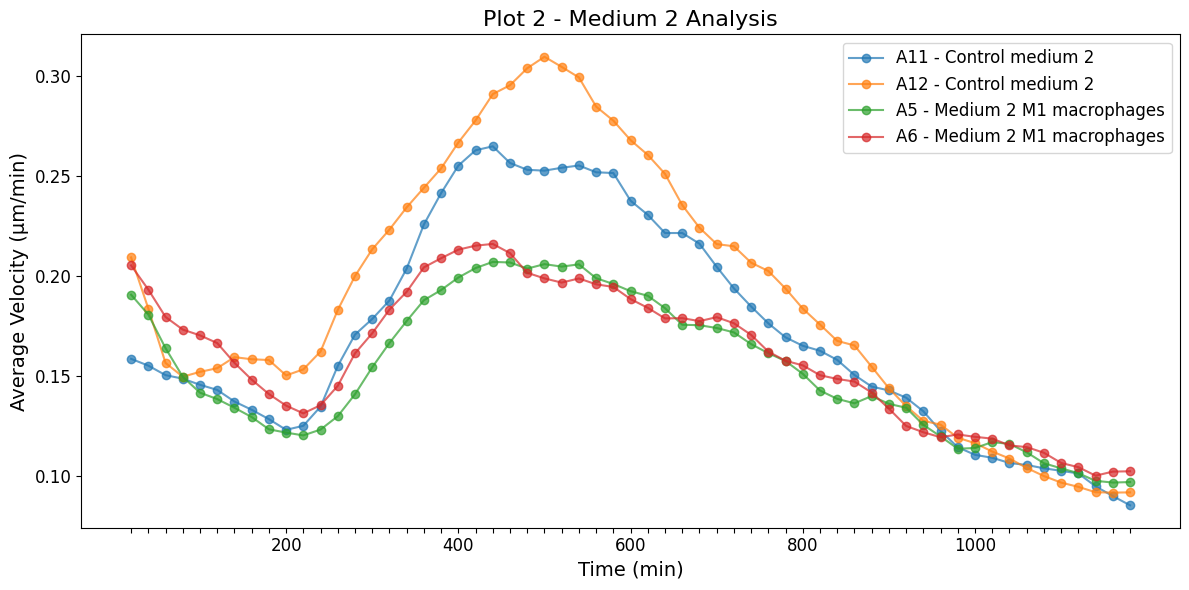

Plot saved for Plot 2 - Medium 2 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_2_-_medium_2_analysis.png


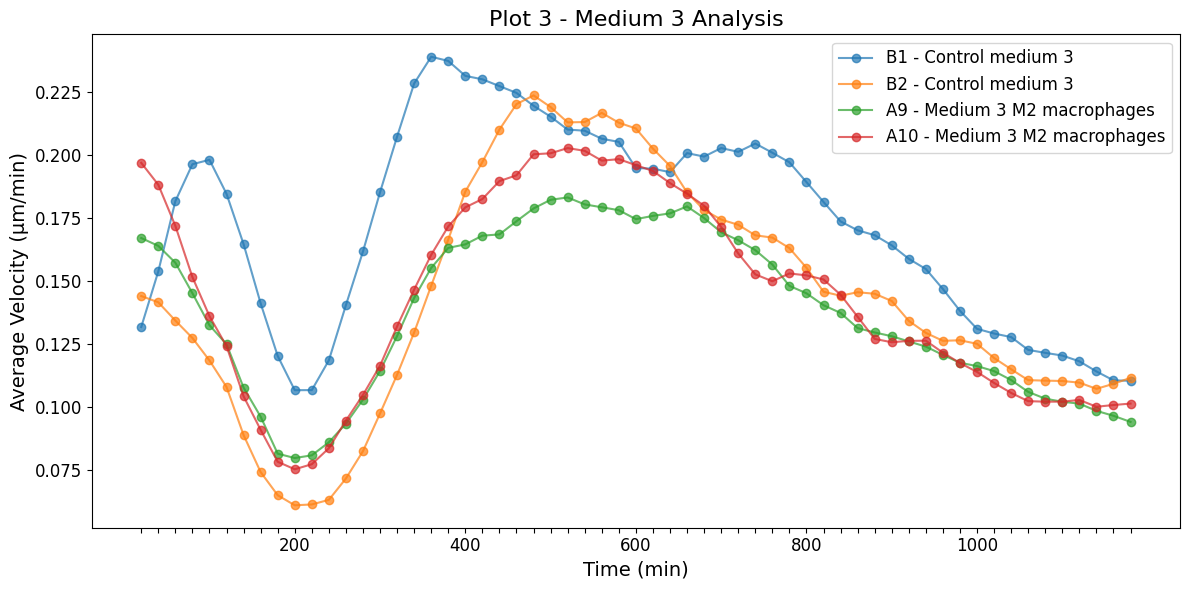

Plot saved for Plot 3 - Medium 3 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_3_-_medium_3_analysis.png


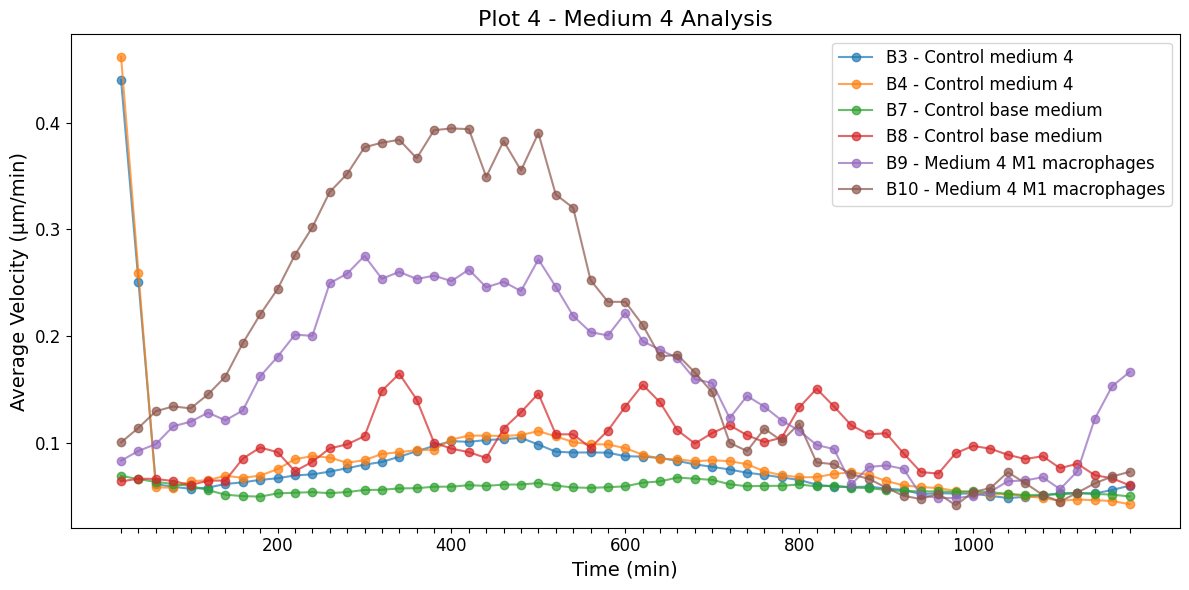

Plot saved for Plot 4 - Medium 4 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_4_-_medium_4_analysis.png


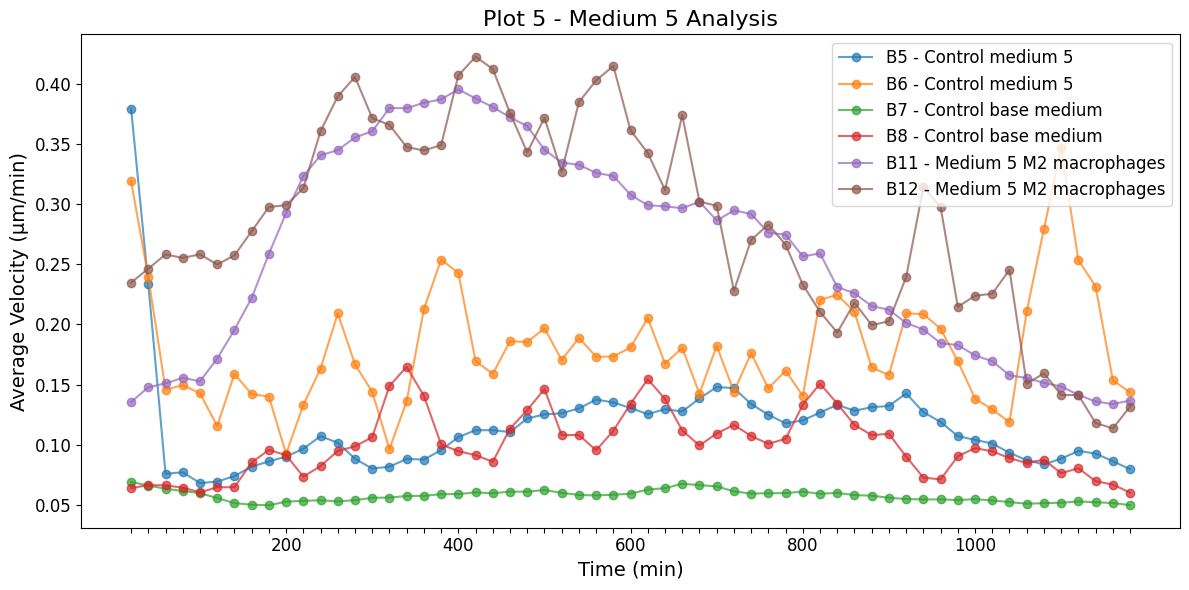

Plot saved for Plot 5 - Medium 5 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_5_-_medium_5_analysis.png


In [61]:
# @title Plot summary graphs A-B

import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d


def plot_specific_graphs(output_folder, smoothing_window=3, x_tick_interval=200):
    """
    Generate 5 specific plots based on the given grouping and titles using the concatenated CSV file.

    Parameters:
    - output_folder: Path where the concatenated CSV file is located and where plots will be saved.
    - smoothing_window: Window size for smoothing (applies uniform filter).
    - x_tick_interval: Interval for x-axis labels.
    """
    # Locate the concatenated CSV file
    csv_files = glob.glob(os.path.join(output_folder, "**", "combined_results_A-B.csv"), recursive=True)

    if not csv_files:
        print(f"No concatenated CSV file found in the output folder: {output_folder}")
        return

    concatenated_csv = csv_files[0]  # Use the first matching file
    print(f"Using concatenated file: {concatenated_csv}")

    # Read the concatenated CSV file
    data = pd.read_csv(concatenated_csv)

    # Map CSV filenames to the described identifiers (A1, B1, etc.)
    data["Identifier"] = data["CSV File Name"].str.extract(r'([AB]\d+)_frames')[0]

    # Define the groups and titles
    plots = [
        (
            [("A1", "Control medium 1"), ("A2", "Control medium 1"),
             ("A3", "Medium 1 M1 macrophages"), ("A4", "Medium 1 M1 macrophages"),
             ("A7", "Medium 1 M2 macrophages"), ("A8", "Medium 1 M2 macrophages")],
            "Plot 1 - Medium 1 Analysis"
        ),
        (
            [("A11", "Control medium 2"), ("A12", "Control medium 2"),
             ("A5", "Medium 2 M1 macrophages"), ("A6", "Medium 2 M1 macrophages")],
            "Plot 2 - Medium 2 Analysis"
        ),
        (
            [("B1", "Control medium 3"), ("B2", "Control medium 3"),
             ("A9", "Medium 3 M2 macrophages"), ("A10", "Medium 3 M2 macrophages")],
            "Plot 3 - Medium 3 Analysis"
        ),
        (
            [("B3", "Control medium 4"), ("B4", "Control medium 4"),
             ("B7", "Control base medium"),  # Explicitly label B7
             ("B8", "Control base medium"),  # Explicitly label B8
             ("B9", "Medium 4 M1 macrophages"), ("B10", "Medium 4 M1 macrophages")],
            "Plot 4 - Medium 4 Analysis"
        ),
        (
            [("B5", "Control medium 5"), ("B6", "Control medium 5"),
             ("B7", "Control base medium"),  # Explicitly label B7
             ("B8", "Control base medium"),  # Explicitly label B8
             ("B11", "Medium 5 M2 macrophages"), ("B12", "Medium 5 M2 macrophages")],
            "Plot 5 - Medium 5 Analysis"
        )
    ]

    def reduce_xticks(time_labels, interval):
        """
        Reduce x-axis ticks to only include labels at specified intervals.
        """
        return [t if t % interval == 0 else "" for t in time_labels]

    # Generate each plot
    for group, plot_title in plots:
        plt.figure(figsize=(12, 6))
        data_found = False

        for identifier, label in group:
            # Filter data for the current identifier
            group_data = data[data["Identifier"] == identifier]

            if group_data.empty:
                print(f"No data found for {identifier} ({label}) in {plot_title}")
                continue


            data_found = True



            # Extract time points and velocities
            time_labels = group_data["End Time Point (min)"]
            avg_velocity = group_data["Avg Velocity (µm/min)"]

            # Apply smoothing
            smoothed_velocity = uniform_filter1d(avg_velocity, size=smoothing_window)

            # Add the identifier to the label for clarity
            plt.plot(
                time_labels,
                smoothed_velocity,
                marker='o',
                label=f"{identifier} - {label}",
                alpha=0.7
            )

        if data_found:
            plt.title(plot_title, fontsize=16)
            plt.xlabel("Time (min)", fontsize=14)
            plt.ylabel("Average Velocity (µm/min)", fontsize=14)
            plt.xticks(
                ticks=time_labels,
                labels=reduce_xticks(time_labels, x_tick_interval),
                fontsize=12
            )
            plt.yticks(fontsize=12)
            plt.legend(loc="upper right", fontsize=12)
            plt.tight_layout()

            # Save the plot
            plot_path = f"{output_folder}/{plot_title.replace(' ', '_').lower()}.png"
            plt.savefig(plot_path, bbox_inches='tight')
            plt.show()
            print(f"Plot saved for {plot_title}: {plot_path}")
        else:
            print(f"No data found for plot: {plot_title}")
            plt.close()


# Example usage

plot_specific_graphs(output_folder=output_folder, smoothing_window=3, x_tick_interval=200)







Using concatenated file: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B/combined_results_A-B.csv


<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

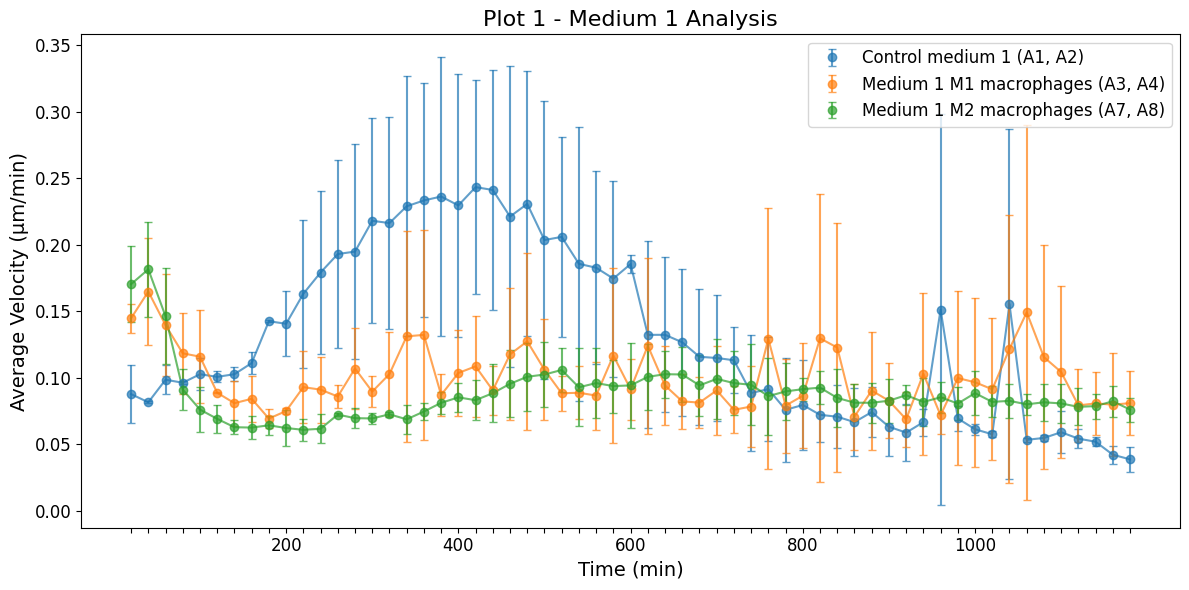

Averaged plot with lines saved for Plot 1 - Medium 1 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_1_-_medium_1_analysis_averaged.png


<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

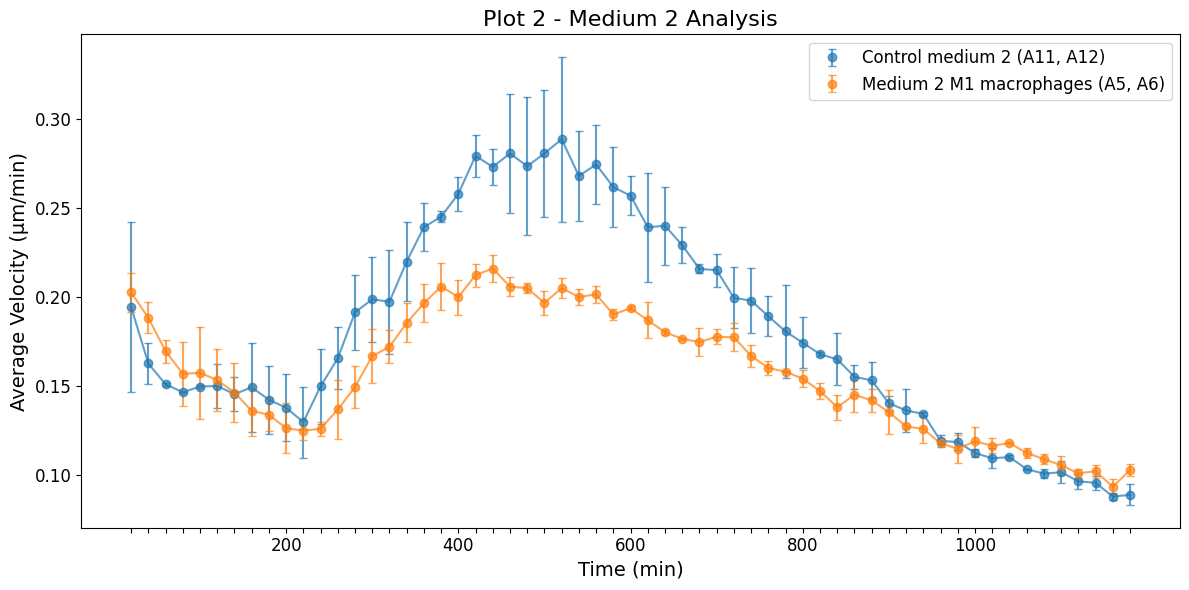

Averaged plot with lines saved for Plot 2 - Medium 2 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_2_-_medium_2_analysis_averaged.png


<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

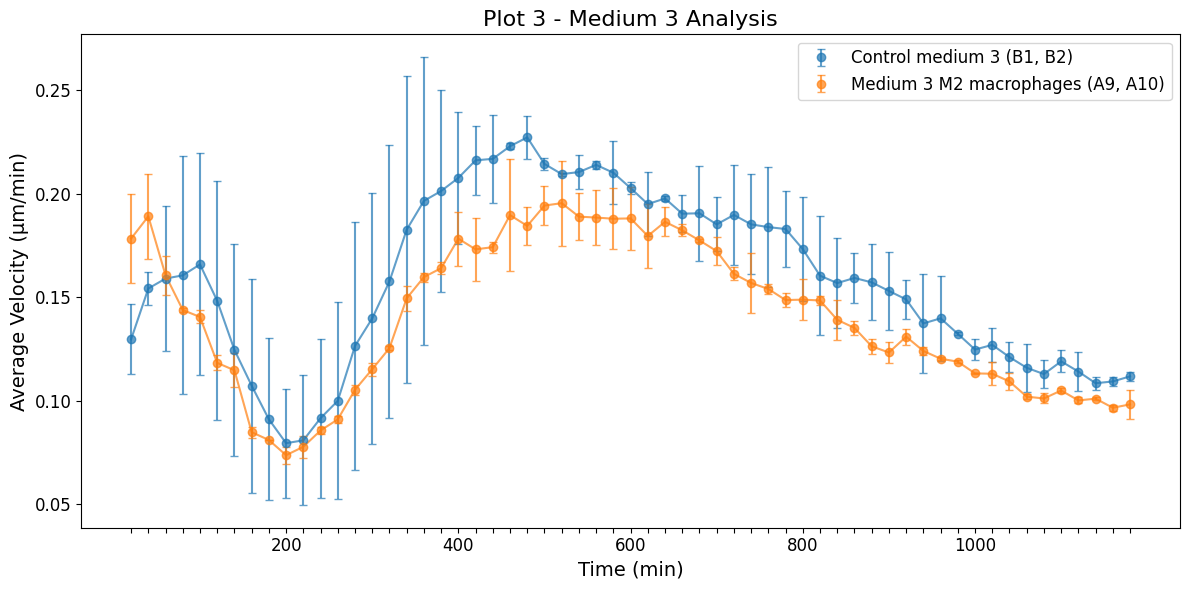

Averaged plot with lines saved for Plot 3 - Medium 3 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_3_-_medium_3_analysis_averaged.png


<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

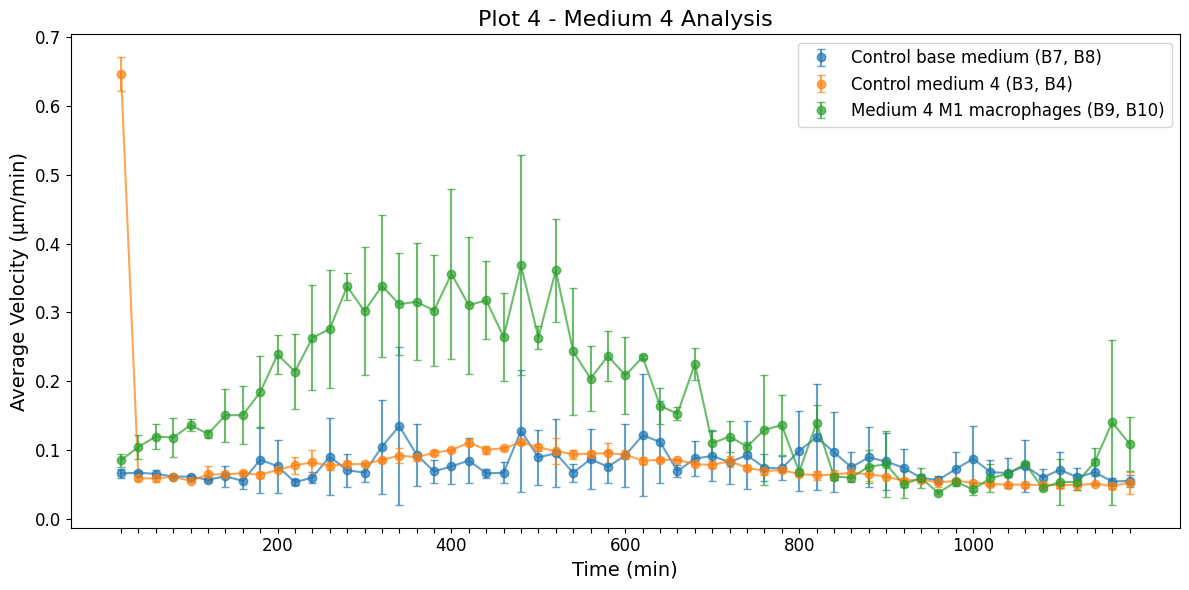

Averaged plot with lines saved for Plot 4 - Medium 4 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_4_-_medium_4_analysis_averaged.png


<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["Group"] = label  # Add a group label column
<ipython-input-62-a1c18a4158ef>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

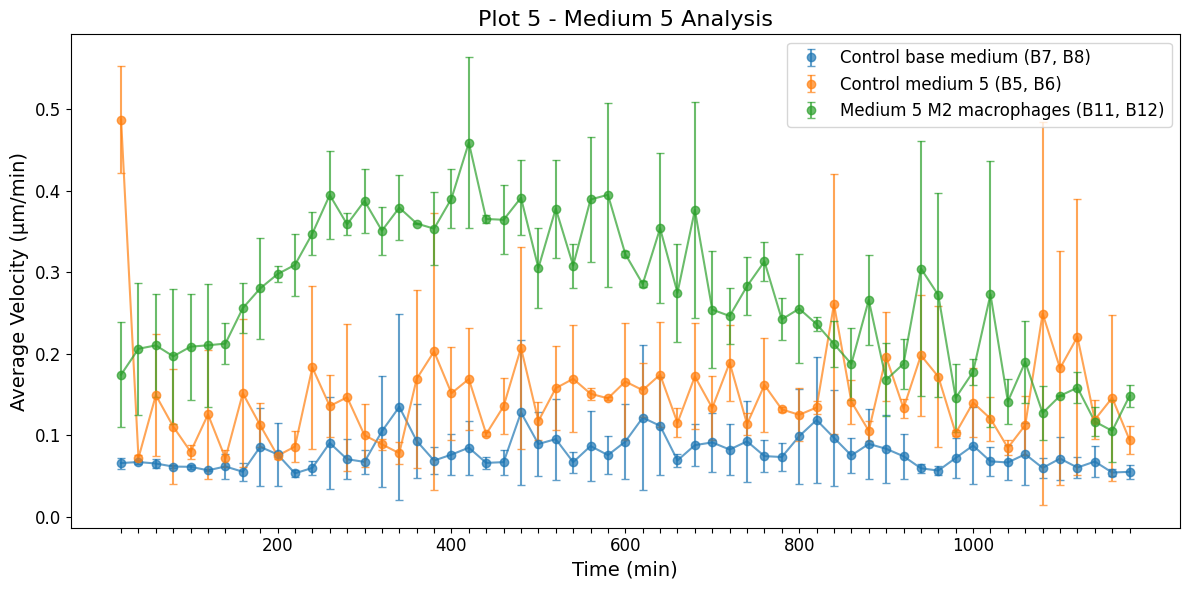

Averaged plot with lines saved for Plot 5 - Medium 5 Analysis: /content/drive/Shareddrives/PIV-analysis/Jammindata2_results_A-B//plot_5_-_medium_5_analysis_averaged.png


In [62]:
# @title Plot averaged summary graphs A-B

import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d


def plot_averaged_graphs_with_combined_identifiers(output_folder, smoothing_window=3, x_tick_interval=200):
    """
    Generate 5 specific plots based on averaging data for groups with the same name.
    Include error bars, combine identifiers in the legend, and add lines between points in the same color.

    Parameters:
    - output_folder: Path where the concatenated CSV file is located and where plots will be saved.
    - smoothing_window: Window size for smoothing (applies uniform filter).
    - x_tick_interval: Interval for x-axis labels.
    """
    # Locate the concatenated CSV file
    csv_files = glob.glob(os.path.join(output_folder, "**", "combined_results_A-B.csv"), recursive=True)

    if not csv_files:
        print(f"No concatenated CSV file found in the output folder: {output_folder}")
        return

    concatenated_csv = csv_files[0]  # Use the first matching file
    print(f"Using concatenated file: {concatenated_csv}")

    # Read the concatenated CSV file
    data = pd.read_csv(concatenated_csv)

    # Map CSV filenames to the described identifiers (A1, B1, etc.)
    data["Identifier"] = data["CSV File Name"].str.extract(r'([AB]\d+)_frames')[0]

    # Define the groups and titles
    plots = [
        (
            [("A1", "Control medium 1"), ("A2", "Control medium 1"),
             ("A3", "Medium 1 M1 macrophages"), ("A4", "Medium 1 M1 macrophages"),
             ("A7", "Medium 1 M2 macrophages"), ("A8", "Medium 1 M2 macrophages")],
            "Plot 1 - Medium 1 Analysis"
        ),
        (
            [("A11", "Control medium 2"), ("A12", "Control medium 2"),
             ("A5", "Medium 2 M1 macrophages"), ("A6", "Medium 2 M1 macrophages")],
            "Plot 2 - Medium 2 Analysis"
        ),
        (
            [("B1", "Control medium 3"), ("B2", "Control medium 3"),
             ("A9", "Medium 3 M2 macrophages"), ("A10", "Medium 3 M2 macrophages")],
            "Plot 3 - Medium 3 Analysis"
        ),
        (
            [("B3", "Control medium 4"), ("B4", "Control medium 4"),
             ("B7", "Control base medium"), ("B8", "Control base medium"),
             ("B9", "Medium 4 M1 macrophages"), ("B10", "Medium 4 M1 macrophages")],
            "Plot 4 - Medium 4 Analysis"
        ),
        (
            [("B5", "Control medium 5"), ("B6", "Control medium 5"),
             ("B7", "Control base medium"), ("B8", "Control base medium"),
             ("B11", "Medium 5 M2 macrophages"), ("B12", "Medium 5 M2 macrophages")],
            "Plot 5 - Medium 5 Analysis"
        )
    ]

    def reduce_xticks(time_labels, interval):
        """
        Reduce x-axis ticks to only include labels at specified intervals.
        """
        return [t if t % interval == 0 else "" for t in time_labels]

    # Generate each plot
    for group, plot_title in plots:
        plt.figure(figsize=(12, 6))
        combined_group_data = []

        # Create a mapping of labels to their identifiers
        label_to_identifiers = {}

        for identifier, label in group:
            group_data = data[data["Identifier"] == identifier]
            if group_data.empty:
                print(f"No data found for {identifier} ({label}) in {plot_title}")
                continue

            # Map label to identifiers
            if label in label_to_identifiers:
                label_to_identifiers[label].append(identifier)
            else:
                label_to_identifiers[label] = [identifier]

            # Append data to combined list
            group_data["Group"] = label  # Add a group label column
            combined_group_data.append(group_data)

        if combined_group_data:
            # Concatenate all data for this plot
            combined_df = pd.concat(combined_group_data, ignore_index=True)

            # Group by time point and label, then calculate mean and std
            grouped = combined_df.groupby(["End Time Point (min)", "Group"]).agg(
                avg_velocity_mean=("Avg Velocity (µm/min)", "mean"),
                avg_velocity_std=("Avg Velocity (µm/min)", "std")
            ).reset_index()

            # Plot each group's mean with error bars and lines
            for label, group_df in grouped.groupby("Group"):
                identifiers = label_to_identifiers[label]
                combined_label = f"{label} ({', '.join(identifiers)})"  # Combine identifiers in the legend

                # Draw error bars and retrieve the line color
                errorbar = plt.errorbar(
                    group_df["End Time Point (min)"],
                    group_df["avg_velocity_mean"],
                    yerr=group_df["avg_velocity_std"],
                    fmt='o',
                    label=combined_label,
                    alpha=0.7,
                    capsize=3
                )

                # Use the same color for the line
                plt.plot(
                    group_df["End Time Point (min)"],
                    group_df["avg_velocity_mean"],
                    linestyle='-',
                    color=errorbar[0].get_color(),
                    alpha=0.7
                )

            plt.title(plot_title, fontsize=16)
            plt.xlabel("Time (min)", fontsize=14)
            plt.ylabel("Average Velocity (µm/min)", fontsize=14)

            # Set reduced x-ticks
            time_labels = grouped["End Time Point (min)"].unique()
            plt.xticks(
                ticks=time_labels,
                labels=reduce_xticks(time_labels, x_tick_interval),
                fontsize=12
            )
            plt.yticks(fontsize=12)
            plt.legend(loc="upper right", fontsize=12)
            plt.tight_layout()

            # Save the plot
            plot_path = f"{output_folder}/{plot_title.replace(' ', '_').lower()}_averaged.png"
            plt.savefig(plot_path, bbox_inches='tight')
            plt.show()
            print(f"Averaged plot with lines saved for {plot_title}: {plot_path}")
        else:
            print(f"No data found for plot: {plot_title}")
            plt.close()


# Example usage
plot_averaged_graphs_with_combined_identifiers(output_folder=output_folder, smoothing_window=3, x_tick_interval=200)






